# Analysis of sequential DNA-MERFISH for CTP07

by Pu Zheng

2022.05.30

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_7\20220528-CTP07chr2_hSTG

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

608


# 1. Pre-processing info

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_7\20220530-CTP07chr2_hSTG_from0308_250gene',
             'save_folder':r'D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':5,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = True

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder', )
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")


88 fovs detected
Use segmentation_folder: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation
Use cand_spot_folder: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\CandSpots
Creating decoder_folder: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Decoder\v6


In [4]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

# 2. Translate segmentation

## 2.1 load rotation matrix

In [8]:
# MERFISH segmentation
merfish_segmentation_folder = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG\CellPoseSegment\features'
merfish_dapi_folder = os.path.join(save_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    os.makedirs(merfish_dapi_folder)
# generate alignment
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear'
rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(fov_param['data_folder'], 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=save_folder)

\\10.245.74.158\Chromatin_NAS_6\20220525-hSTG0308_250gene_noclear\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_7\20220530-CTP07chr2_hSTG_from0308_250gene\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99998373 -0.00570495]
 [ 0.00570495  0.99998373]],
 translation:[ -604.64747625 -1111.79051993]
-- rotation matrix saved to file:D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\rotation
-- translation matrix saved to file:D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\translation


## 2.2 save DAPI image for RNA

In [6]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 25
- Number of field of views: 138


In [7]:
# trim first 50 fov because of imaging bleaching problem
rna_fovs = rna_fovs[50:]

In [8]:
len(rna_fovs), len(save_fov_ids)

(88, 88)

In [9]:
%%time
overwrite_dapi = False
rna_ref_fd = rna_fds[0]

for _save_filename, _rna_fov_name in zip(save_filenames, rna_fovs):
    #print(_save_filename, _rna_fov_name)
    _dapi_savefile = os.path.join(merfish_dapi_folder, os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    print(f"- processing dapi into file: {_dapi_savefile}")
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _dax_filename = os.path.join(rna_ref_fd, _rna_fov_name)
        print(f"-- loading dapi from file: {_dax_filename}")
        _dax_cls = ia.classes.preprocess.DaxProcesser(_dax_filename, 
                                                      CorrectionFolder=fov_param['correction_folder'], 
                                                      DriftChannel=488, DapiChannel=405)
        _dax_cls._load_image(sel_channels=[405])
        _dax_cls._corr_illumination()
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dax_cls.im_405)
    else:
        print(f"-- file already exists, skip loading DAPI. ")

- processing dapi into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Merfish_DAPI\Conv_zscan_00_Dapi.npy
-- file already exists, skip loading DAPI. 
- processing dapi into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Merfish_DAPI\Conv_zscan_01_Dapi.npy
-- file already exists, skip loading DAPI. 
- processing dapi into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Merfish_DAPI\Conv_zscan_02_Dapi.npy
-- file already exists, skip loading DAPI. 
- processing dapi into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Merfish_DAPI\Conv_zscan_03_Dapi.npy
-- file already exists, skip loading DAPI. 
- processing dapi into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Merfish_DAPI\Conv_zscan_04_Dapi.npy
-- file already exists, skip loading DAPI. 
- processing dapi into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Merfish_DAPI\Conv_zscan_05_Dapi.npy
-- file already exists, skip loading DAPI. 
- processing dapi into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Merfish_D

## 2.3 Prepare args

In [6]:
segmentation_savefiles = []

In [7]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
rna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [8]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, rna_microscope_file, dna_microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

88
Wall time: 223 ms


## 2.4 test run and plot

In [26]:
reload(ia.segmentation_tools.cell)

<module 'ImageAnalysis3.segmentation_tools.cell' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\cell.py'>

In [27]:
import ImageAnalysis3.segmentation_tools.cell
sel_fov = 1
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

dna_mask, _full_rna_mask, _rna_dapi, _rot_dna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [  0.  -12.4   2. ] in 1.484s.
-- drift 1: [ 0.1 -9.5 -0.3] in 1.485s.
-- drift 2: [ 0.1 -0.1  0. ] in 1.515s.
-- drift 3: [ 0.1 -7.1 -1.4] in 1.524s.
-- drift 4: [ 0.1 -6.9 -0.2] in 1.497s.
-- drift 5: [  0.  -12.4  -0.6] in 1.528s.
-- drift 6: [ 0.1 -9.  -0.8] in 1.509s.
-- drift 7: [ 0.1 -8.5 -0.5] in 1.537s.
-- return a sub-optimal drift
--- drift: [ 0.1  -9.   -0.53] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


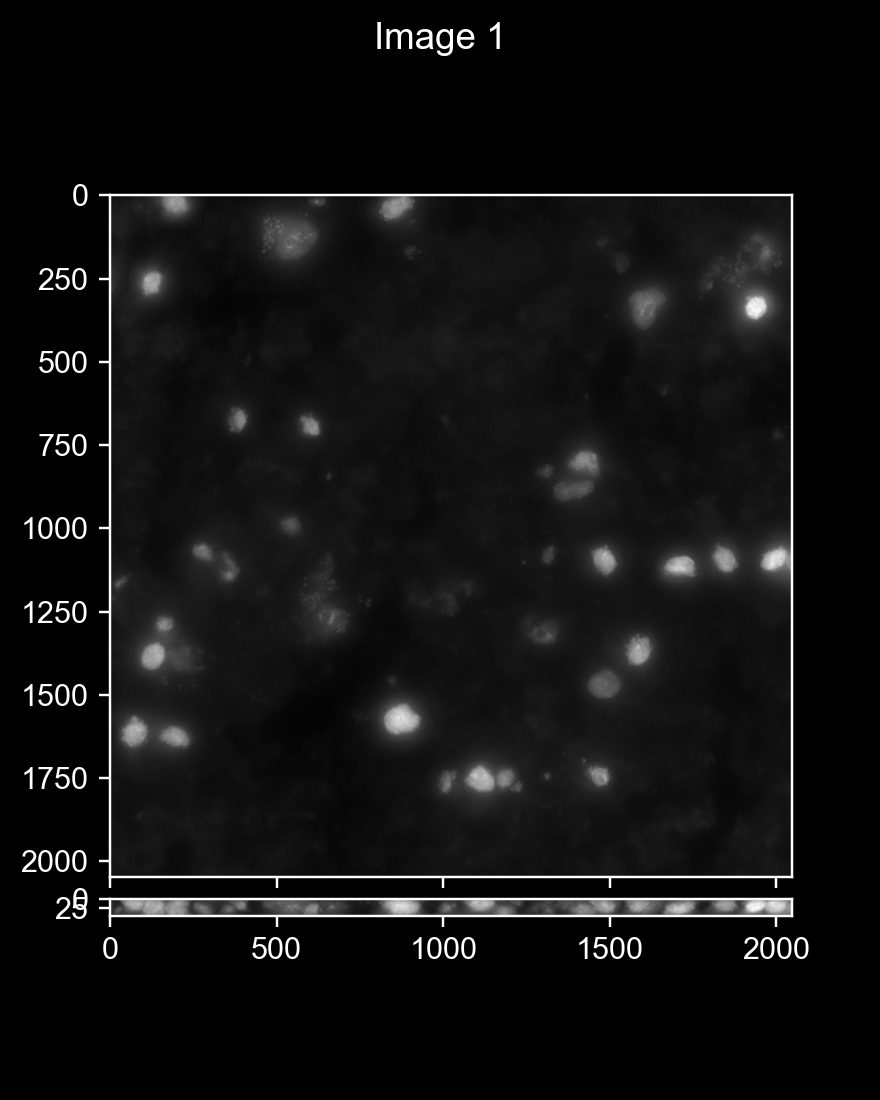

In [28]:
visual_tools.imshow_mark_3d_v2([_dna_dapi, dna_mask])

<IPython.core.display.Javascript object>


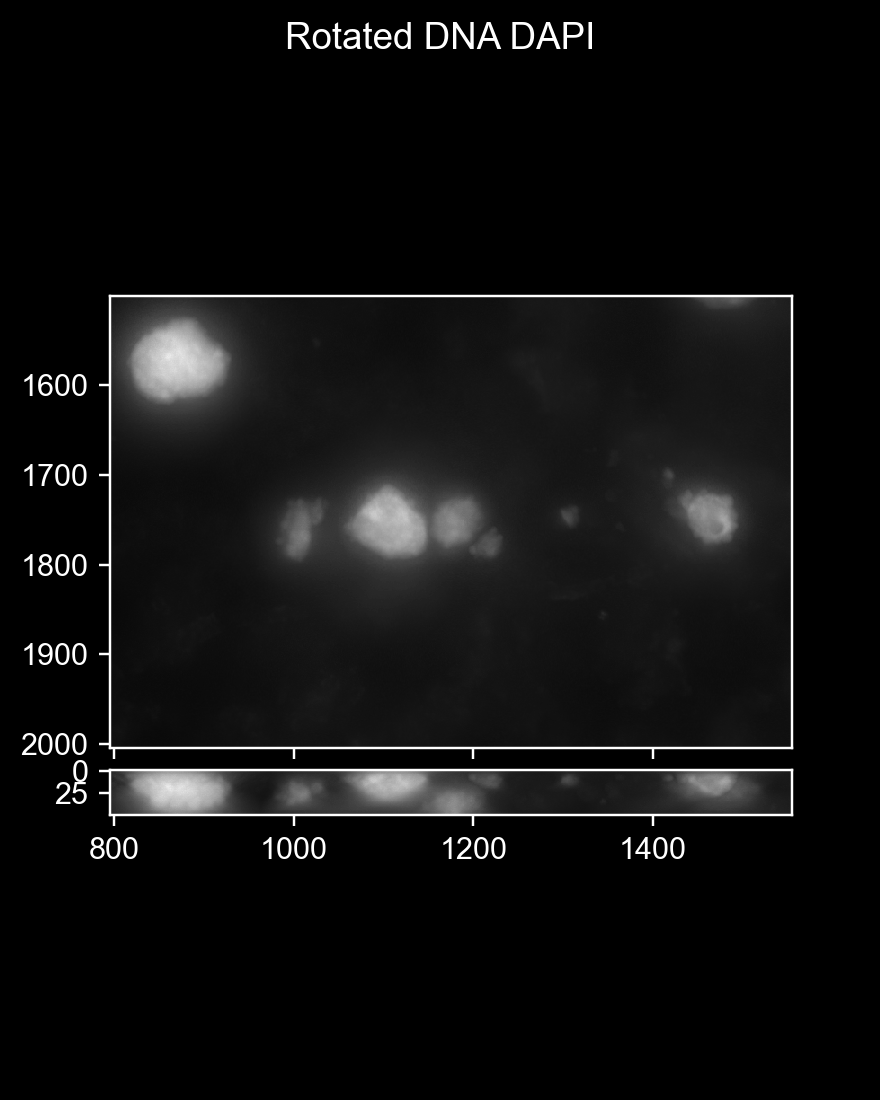

In [22]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi, _rna_dapi, _rot_dna_dapi], 
                                         #min_max_default=[10000,50000], 
                                         image_names=['DNA DAPI', 'RNA DAPI', 'Rotated DNA DAPI'])
#_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

<IPython.core.display.Javascript object>


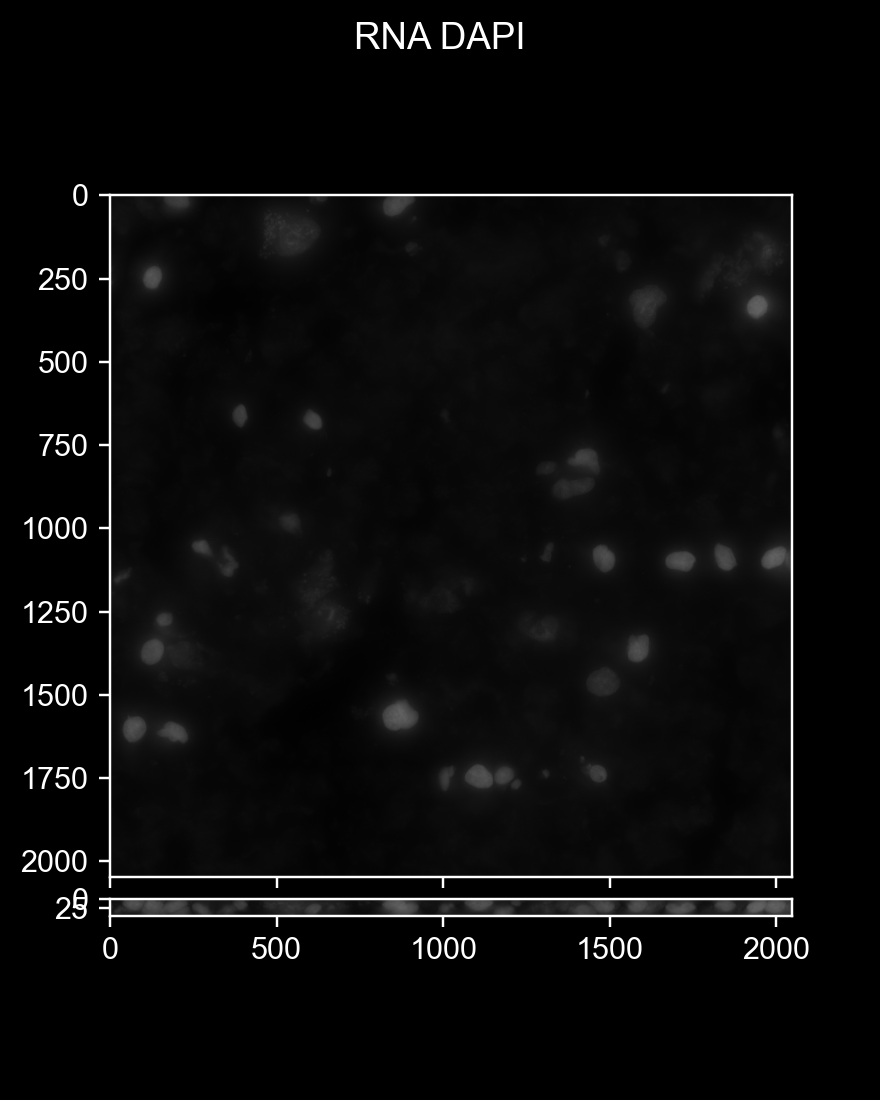

In [29]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_rna_dapi], 
                                         #min_max_default=[500,8000], 
                                         image_names=['RNA DAPI'])
#_vis.f.savefig(os.path.join(segmentation_folder, 'test_rna_dapi.png'), transparent=True)

## 2.5 batch run translation

In [9]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(6) as _seg_pool: # 6 cores recommended because of RAM comsumption
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 1220.038s. 
Wall time: 20min 34s


# 3 Partition DNA-MERFISH spots

In [5]:
from ImageAnalysis3.classes.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.figure_tools import plot_partition
import pandas as pd

In [6]:
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
import ImageAnalysis3.io_tools.spots 
reload(segmentation_tools.cell)
reload(io_tools.spots)
reload(ia.classes.preprocess)
reload(ia.classes.partition_spots)

<module 'ImageAnalysis3.classes.partition_spots' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\partition_spots.py'>

In [24]:
with h5py.File(_save_filename, 'r') as _f:
    _unique_spots = [Spots3D(_s[_s[:,0]>0]) for _s in _f[r'unique/spots'][:]]

In [41]:
from ImageAnalysis3 import _distance_zxy, _image_size
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.io_tools.parameters import _read_microscope_json

    
translated_spots = MicroscopeTranslate_Spots(_unique_spots[0], dna_microscope_file)

[  31.571156  950.1041   1690.6288  ]


In [40]:
with h5py.File(os.path.join(segmentation_folder, r'Conv_zscan_87_Segmentation.hdf5'), 'r') as _f:
    print(_f['87'].keys())
    seg_labels = _f['87']['dna_mask'][:]

<KeysViewHDF5 ['cell_2_uid', 'dna_mask']>


<IPython.core.display.Javascript object>


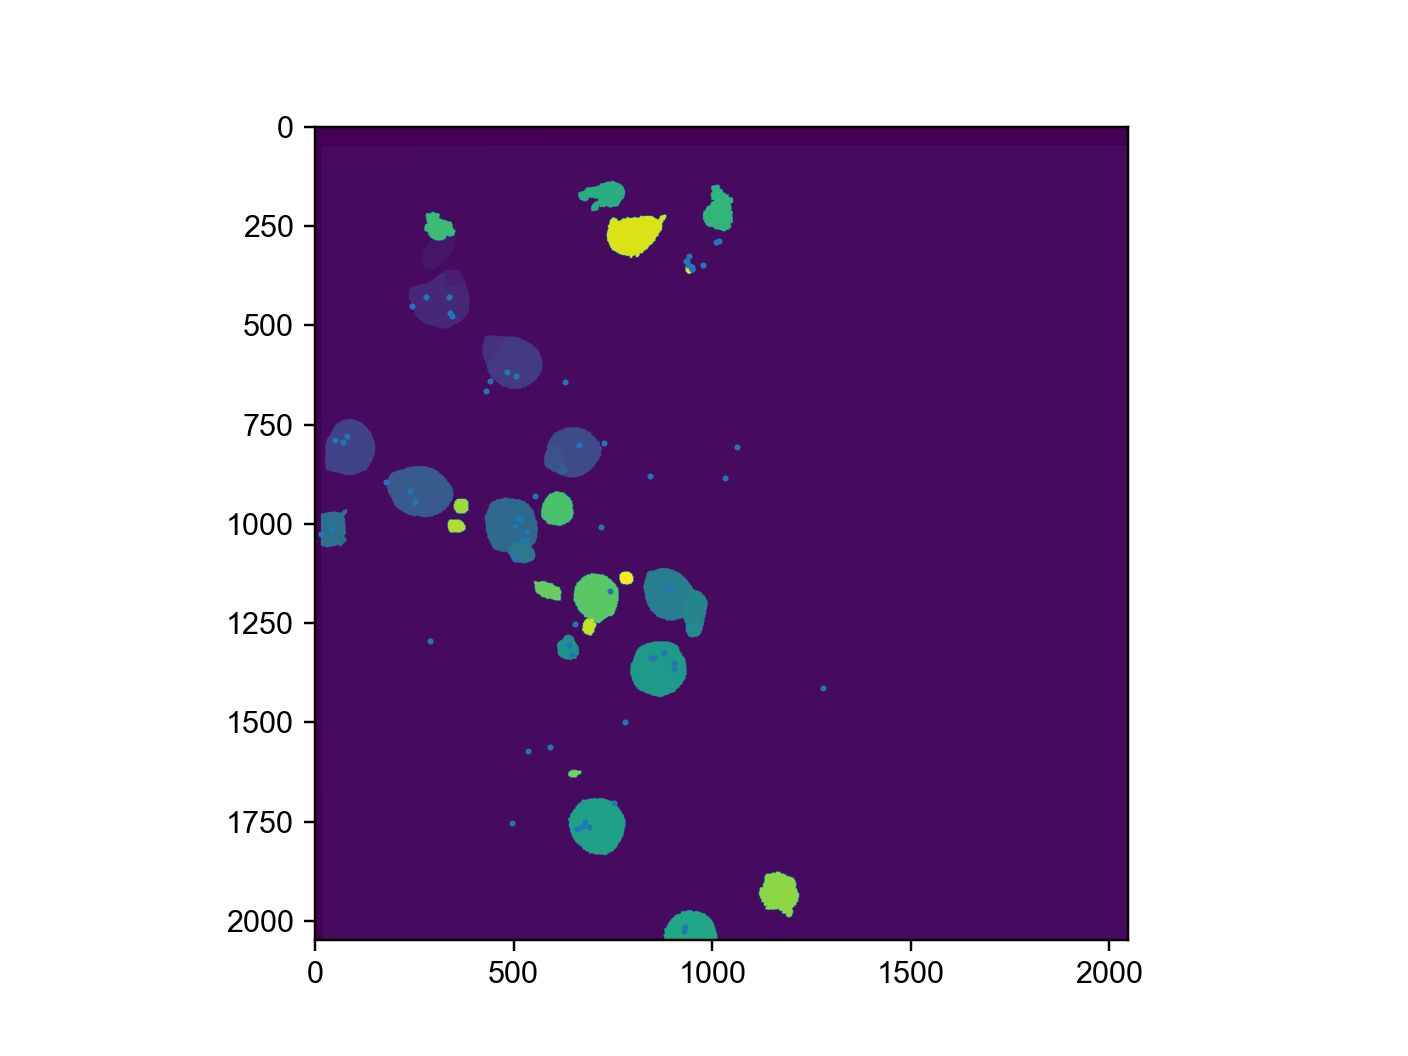

In [44]:
plt.figure()
plt.imshow(seg_labels.max(0))
plt.scatter(translated_spots[:,3], translated_spots[:,2], s=1)
plt.show()

## 3.1 prepare spots for partition


In [7]:
search_radius = 3
overwrite_cand_spots = False
add_relabel_spots = False
data_type = 'unique' # 'combo'
#_total_seg_save_file defined in 2.3
_partition_args = []

# load microscope.json
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'

In [11]:
%%time
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):

    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(_cand_spot_filename) and not overwrite_cand_spots:
        continue
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', '', np.array([]))
    _align_seg._load(_segmentation_savefile)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    # load spots
    spots_list, combo_bits = ia.io_tools.spots.load_preprocess_spots(
        _save_filename, data_type, None, pixel_sizes=pixel_sizes,
    )
    # add relabeled spots if specified.
    if add_relabel_spots:
        relabel_spots_list, relabel_bits = ia.io_tools.spots.load_preprocess_spots(
            _save_filename, f'relabeled_{data_type}', None, pixel_sizes=pixel_sizes,
        )
        for _rspots, _rbit in zip(relabel_spots_list, relabel_bits):
            _ind = list(combo_bits).index(_rbit)
            _old_spots = spots_list[_ind]
            # merge
            _merged_spots = ia.io_tools.spots.merge_RelabelSpots(
                _old_spots, _rspots, pixel_sizes=pixel_sizes,
            )
            # replace
            spots_list[_ind] = _merged_spots
    # 
    _all_spots = ia.io_tools.spots.merge_Spots3DList(spots_list, pixel_sizes=pixel_sizes)
    # partition args
    _args = (
        _fov_id, 
        np.array(_all_spots), _all_spots.bits, _all_spots.channels,
        seg_label, fovcell_2_uid,
        dna_microscope_file,
        search_radius, pixel_sizes,
        True, 
        True, _cand_spot_filename,
        True, 5, 
        False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

-- loading segmentation info from fov:4 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_04_Segmentation.hdf5
-- loading segmentation info from fov:5 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_05_Segmentation.hdf5
-- loading segmentation info from fov:6 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_06_Segmentation.hdf5
-- loading segmentation info from fov:7 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_07_Segmentation.hdf5
-- loading segmentation info from fov:8 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_08_Segmentation.hdf5
-- loading segmentation info from fov:9 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_09_Segmentation.hdf5
-- loading segmentation info from fov:10 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_10_Segmentation.hdf5
-- loading segmenta

-- loading segmentation info from fov:63 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_63_Segmentation.hdf5
-- loading segmentation info from fov:64 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_64_Segmentation.hdf5
-- loading segmentation info from fov:65 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_65_Segmentation.hdf5
-- loading segmentation info from fov:66 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_66_Segmentation.hdf5
-- loading segmentation info from fov:67 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_67_Segmentation.hdf5
-- loading segmentation info from fov:68 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_68_Segmentation.hdf5
-- loading segmentation info from fov:69 into file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Segmentation\Conv_zscan_69_Segmentation.hdf5
-- loading se

In [12]:
%%time
import multiprocessing as mp
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(32) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(ia.classes.partition_spots.batch_partition_DNA_spots, 
                            _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 64.350s. 
Wall time: 1min 4s


In [57]:
reload(ia.classes.partition_spots)
reload(ia.classes.spot_tools.translating)

<module 'ImageAnalysis3.spot_tools.translating' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\spot_tools\\translating.py'>

- Partition cand_spots for fov:0
-- partition barcodes for 11761 spots


11761it [00:00, 19759.20it/s]


- Save 11678 spots to file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\CandSpots\Conv_zscan_00_CandSpots.csv


<IPython.core.display.Javascript object>


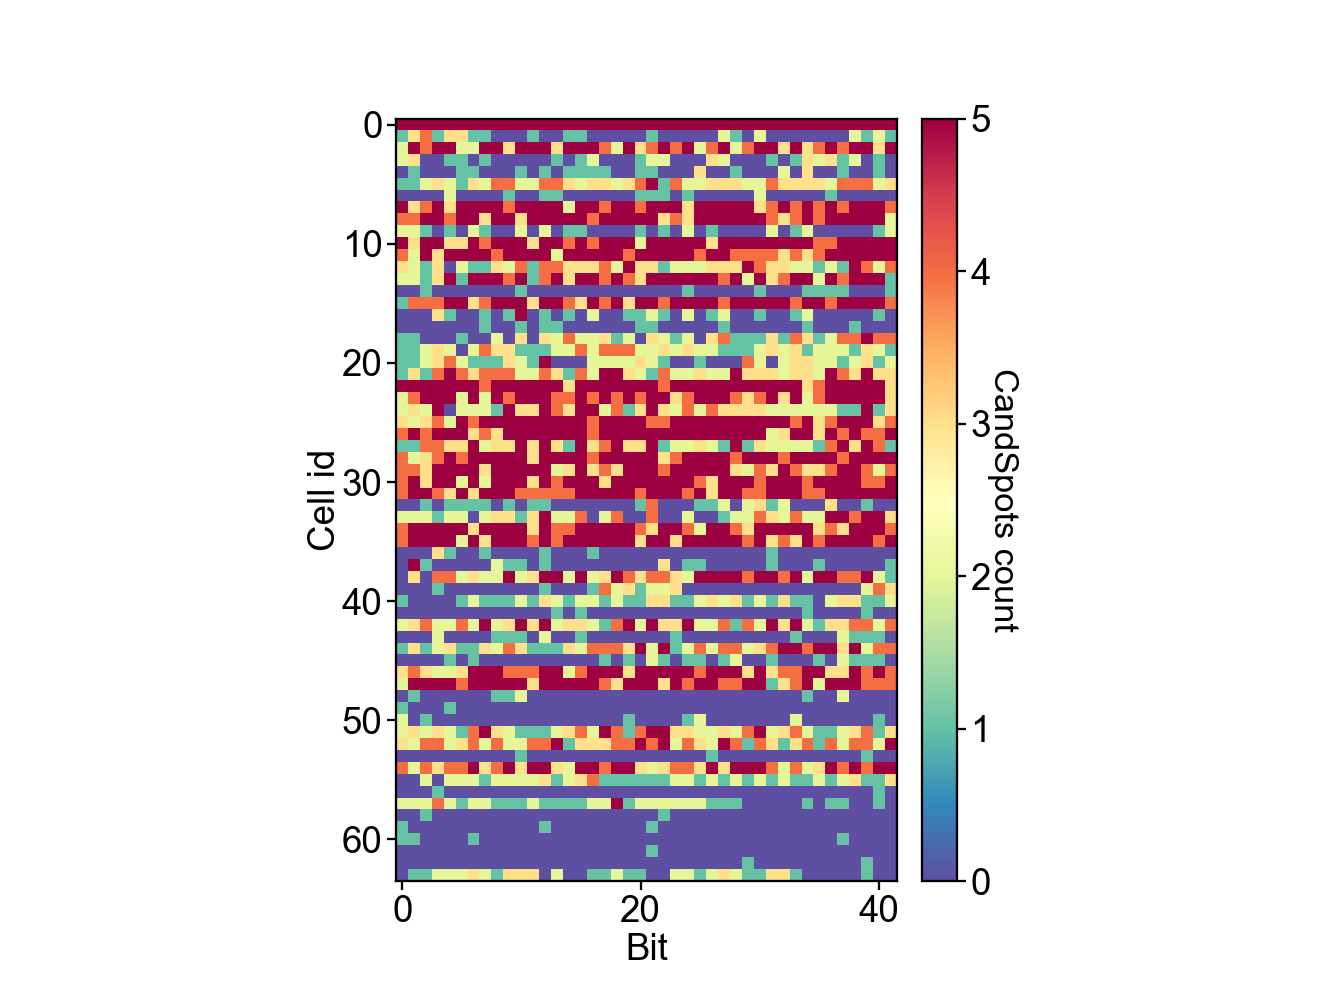

-- save iamage to file: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\CandSpots\Figures\Fov-0_SpotCountPerCell.png
-- finish partition in 1.774s. 


In [65]:
# sequential
for _args in _partition_args:
    ia.classes.partition_spots.batch_partition_DNA_spots(*_args)
    break

# 3. Spot_picking of sequential DNA-FISH

In [13]:

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing sequential spots for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
        
    break

- Preparing sequential spots for fov: 0


'Conv_zscan_00_Segmentation.hdf5'

In [48]:
from ImageAnalysis3.classes import decode
from ImageAnalysis3.segmentation_tools import cell
from ImageAnalysis3.io_tools.parameters import _read_microscope_json

# load microscope.json
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_param = _read_microscope_json(dna_microscope_file)

In [18]:
for _cell_id in np.unique(_fov_spots_df['cell_id']):
    _cell_spots_df = _fov_spots_df.loc[_fov_spots_df['cell_id'] == _cell_id]
    print(len(_cell_spots_df))

4926
32
197
36
22
118
12
242
231
28
247
224
114
198
9
236
30
9
80
89
69
134
287
207
122
223
261
130
234
210
228
242
29
105
219
234
8
35
159
29
64
4
132
15
128
19
200
218
8
2
10
121
138
3
182
67
2
55
2
3
4
1
2
53


In [49]:
# load segmentation_mask
_segmentation_savefile = os.path.join(segmentation_folder, os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5'))
_seg_labels = decode.load_hdf5_array(_segmentation_savefile, f'{str(_fov_id)}/dna_mask')
_cell_2_uid = classes.decode.load_hdf5_dict(_segmentation_savefile, f'{str(_fov_id)}/cell_2_uid')

# load dapi and chromosome images
with h5py.File(_save_filename, 'r') as _f:
    dapi_im = _f.attrs['dapi_im']
    chrom_im = _f.attrs['chrom_im']
    
dapi_im = cell.Align_Segmentation._correct_image3D_by_microscope_param(dapi_im, dna_microscope_param)
chrom_im = cell.Align_Segmentation._correct_image3D_by_microscope_param(chrom_im, dna_microscope_param)

## find chromosomes

In [51]:
from ImageAnalysis3.segmentation_tools import chromosome
reload(chromosome)

<module 'ImageAnalysis3.segmentation_tools.chromosome' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\chromosome.py'>

In [52]:
chrom_coords = chromosome.find_candidate_chromosomes_in_nucleus(chrom_im, dapi_im, _seg_labels>0)

-- binarize image with threshold: 3.3950356425130583
-- iterative dilation to increase initial binary seed size
-- iterative dilation to increase initial binary seed size
-- there are 97 objects after initial segmentation


E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:180: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  _2chr_binary_im = morphology.remove_small_objects(_minus_binary_im, _size_th_2chr).astype(np.uint16)   # large (or intermediate) seed


-- process small chromosome seeds with size=1.
-- process large/intermediate chromosome seeds with size=2.
-- process larger chromosome seeds with size=2. closing seeds with size=2
-- random walk segmentation, beta=15.


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\skimage\segmentation\random_walker_segmentation.py:470: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  inds_isolated_seeds, isolated_values) = _preprocess(labels)


-- 68 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 4 threads in 100.829s.


In [60]:
coord_dict = {'coords':[np.flipud(_coord) for _coord in chrom_coords[:,:-1]],
              'class_ids':list(np.zeros(len(chrom_coords),dtype=np.int32)),
             }


<IPython.core.display.Javascript object>


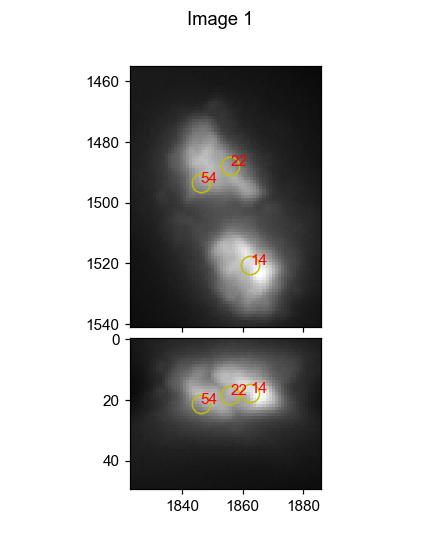

In [61]:
visual_tools.imshow_mark_3d_v2([chrom_im, dapi_im, _seg_labels], given_dic=coord_dict)

# 3. Decoding of DNA-MERFISH

In [64]:
# load two codebooks
import pandas as pd
codebook_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
codebook_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
codebook_se['id'] = codebook_se['id'] + np.max(codebook_gn['id'])

### re-sort chr_order

In [65]:
# combine region_ids
merged_codebook = pd.concat([codebook_gn, codebook_se], axis=0, join='outer',ignore_index=True).fillna(0)

merged_codebook['reg_start'] = [int(_name.split(':')[1].split('-')[0]) for _name in merged_codebook['name']]
merged_codebook['reg_end'] = [int(_name.split(':')[1].split('-')[1]) for _name in merged_codebook['name']]
merged_codebook['reg_mid'] = (merged_codebook['reg_start'] + merged_codebook['reg_end'])/2

for _chr in np.unique(merged_codebook['chr']):
    _chr_codebook = merged_codebook[merged_codebook['chr']==_chr]
    _reg_order = np.argsort(merged_codebook.loc[merged_codebook['chr']==_chr, 'reg_mid'])
    merged_codebook.loc[_chr_codebook.index[_reg_order], 'chr_order'] = np.arange(len(_chr_codebook))
    
# cleanup 
codebook_df = merged_codebook[[_c for _c in merged_codebook.columns if 'reg_' not in _c]]

In [66]:
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3740000-3760000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6240000-6260000,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740000-8760000,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1:11240000-11260000,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1:13740000-13760000,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,X:101910335-102015609,2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1952,X:136772307-136851006,2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,X:140481839-140547985,2051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,X:167122110-167191320,2052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
codebook_df.to_csv(os.path.join(decoder_folder, 'merged_codebook.csv'), index=False)

## 3.2 load spot files

In [79]:
with h5py.File(save_filenames[0], "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_channels = [_ch.decode() for _ch in _grp['channels'][:]]
    combo_ids = _grp['ids'][:]
    
bit_2_channel = {_b:_ch for _b,_ch in zip(combo_ids, combo_channels)}

## 3.3 prepare decoding args

In [80]:
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [81]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import decode
reload(decode)

overwrite_decoder = False
return_decoder = False
skip_exist = True
load_exist = True

pair_search_radius = 300

decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f'Fov-{_fov_id}_Cell-{_cell_id}_Decoder.hdf5')
        if os.path.exists(_decoder_filename) and skip_exist:
            continue
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]

        _args = (_cell_spots_df, codebook_df, _decoder_filename, combo_ids,
                 False, True, bit_2_channel,
                 pixel_sizes, 2, 0.1, 
                 pair_search_radius, -1, 1, 5, 0, -25, # v0 was 4
                 load_exist, overwrite_decoder, return_decoder, False) 
        # append
        decode_args.append(_args)
    
print(len(decode_args))

- Preparing decoding args for fov: 0
- Preparing decoding args for fov: 1
- Preparing decoding args for fov: 2
- Preparing decoding args for fov: 3
- Preparing decoding args for fov: 4
- Preparing decoding args for fov: 5
- Preparing decoding args for fov: 6
- Preparing decoding args for fov: 7
- Preparing decoding args for fov: 8
- Preparing decoding args for fov: 9
- Preparing decoding args for fov: 10
- Preparing decoding args for fov: 11
- Preparing decoding args for fov: 12
- Preparing decoding args for fov: 13
- Preparing decoding args for fov: 14
- Preparing decoding args for fov: 15
- Preparing decoding args for fov: 16
- Preparing decoding args for fov: 17
- Preparing decoding args for fov: 18
- Preparing decoding args for fov: 19
- Preparing decoding args for fov: 20
- Preparing decoding args for fov: 21
- Preparing decoding args for fov: 22
- Preparing decoding args for fov: 23
- Preparing decoding args for fov: 24
- Preparing decoding args for fov: 25
- Preparing decoding a

## 3.4 test decode one cell

In [39]:
# test run one cell
%matplotlib inline
reload(decode)
_cell_ind = 20
test_arg = list(decode_args[_cell_ind])
test_arg[16] = True
test_arg[18] = True
decoder = decode.batch_decode_DNA(*tuple(test_arg))

Creating DNA_Merfish_Decoder class.
- 26848 pairs kept given search radius 300 nm.
-- search spot_groups given search radius 300 nm, max_usage=1


100%|██████████████████████████████████████████████████████████████████████████| 26848/26848 [00:12<00:00, 2099.55it/s]


- 5351 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
- Saving decoder into file: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- save cand_spots into: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- save spot_groups into: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5


E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:150: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'start', 'end',
       'chr'],
      dtype='object')]

  decoder_group_df.to_hdf(self.savefile, 'spot_groups', complevel=_complevel, complib=_complib)


-- save spot_groups into: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- seeding chr:1 with 153 regions with 480 spot_groups
-- init 2 homologs for chr:1
- diff in iter-0: 0.3312
- diff in iter-1: 0.1062
- diff in iter-2: 0.2083
- diff in iter-3: 0.1583
- diff in iter-4: 0.0771
- diff in iter-5: 0.0354
- diff in iter-6: 0.0042
- diff in iter-7: 0.0063
- diff in iter-8: 0.0042
- diff in iter-9: 0.0000
-- seeding chr:10 with 115 regions with 314 spot_groups
-- init 2 homologs for chr:10
- diff in iter-0: 0.4236
- diff in iter-1: 0.1879
- diff in iter-2: 0.0573
- diff in iter-3: 0.0255
- diff in iter-4: 0.0127
- diff in iter-5: 0.0064
- diff in iter-6: 0.0000
-- seeding chr:11 with 105 regions with 288 spot_groups
-- init 2 homologs for chr:11
- diff in iter-0: 0.3750
- diff in iter-1: 0.1667
- diff in iter-2: 0.1007
- diff in iter-3: 0.0556
- diff in iter-4: 0.0590
- diff in iter-5: 0.0625
- diff in iter-6: 0.0451
- diff in ite

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


- diff in iter-0: 0.4026
- diff in iter-1: 0.0649
- diff in iter-2: 0.0260
- diff in iter-3: 0.0000
-- seeding chr:Y with 1 regions with *2 spot_groups
- processing chr:1
- diff in iter-0: 0.5364
- diff in iter-1: 0.0104
- diff in iter-2: 0.0083
- diff in iter-3: 0.0021
- diff in iter-4: 0.0000
- processing chr:10
- diff in iter-0: 0.4984
- diff in iter-1: 0.0252
- diff in iter-2: 0.0032
- diff in iter-3: 0.0063
- diff in iter-4: 0.0126
- diff in iter-5: 0.0126
- diff in iter-6: 0.0032
- diff in iter-7: 0.0000
- processing chr:11
- diff in iter-0: 0.5087
- diff in iter-1: 0.0415
- diff in iter-2: 0.0208
- diff in iter-3: 0.0104
- diff in iter-4: 0.0104
- diff in iter-5: 0.0000
- processing chr:12
- diff in iter-0: 0.4788
- diff in iter-1: 0.0154
- diff in iter-2: 0.0000
- processing chr:13
- diff in iter-0: 0.4786
- diff in iter-1: 0.0934
- diff in iter-2: 0.0272
- diff in iter-3: 0.0428
- diff in iter-4: 0.0856
- diff in iter-5: 0.1051
- diff in iter-6: 0.0817
- diff in iter-7: 0.0389

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/1/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/10/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/10/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/11/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '11'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/11/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/12/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '12'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/12/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/13/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '13'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/13/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/14/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '14'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/14/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/15/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '15'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/15/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/16/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '16'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/16/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/17/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '17'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/17/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/18/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '18'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/18/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/19/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '19'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_

-- save tuples for :chr_2_assigned_tuple_list/19/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/2/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/2/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/3/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '3'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/3/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/4/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '4'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/4/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/5/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '5'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/5/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/6/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/6/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/7/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '7'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/7/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/8/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '8'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/8/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/9/0


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '9'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1

-- save tuples for :chr_2_assigned_tuple_list/9/1


E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'start', 'end', 'chr', 'channel_2'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- save tuples for :chr_2_assigned_tuple_list/X/0
- Update chr_2_indices_list into \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- saving 1 in chr_2_indices_list
-- saving 10 in chr_2_indices_list
-- saving 11 in chr_2_indices_list
-- saving 12 in chr_2_indices_list
-- saving 13 in chr_2_indices_list
-- saving 14 in chr_2_indices_list
-- saving 15 in chr_2_indices_list
-- saving 16 in chr_2_indices_list
-- saving 17 in chr_2_indices_list
-- saving 18 in chr_2_indices_list
-- saving 19 in chr_2_indices_list
-- saving 2 in chr_2_indices_list
-- saving 3 in chr_2_indices_list
-- saving 4 in chr_2_indices_list
-- saving 5 in chr_2_indices_list
-- saving 6 in chr_2_indices_list
-- saving 7 in chr_2_indices_list
-- saving 8 in chr_2_indices_list
-- saving 9 in chr_2_indices_list
-- saving X in chr_2_indices_list
- Update chr_2_zxys_list into \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_

E:\Users\puzheng\AppData\anaconda3\envs\ia3_postanalysis\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:770: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['channel_0', 'channel_1', 'channel_2', 'start', 'end', 'chr'], dtype='object')]

  _df.to_hdf(self.savefile, _key, complevel=_complevel, complib=_complib)


-- saving 1 in chr_2_zxys_list
-- saving 10 in chr_2_zxys_list
-- saving 11 in chr_2_zxys_list
-- saving 12 in chr_2_zxys_list
-- saving 13 in chr_2_zxys_list
-- saving 14 in chr_2_zxys_list
-- saving 15 in chr_2_zxys_list
-- saving 16 in chr_2_zxys_list
-- saving 17 in chr_2_zxys_list
-- saving 18 in chr_2_zxys_list
-- saving 19 in chr_2_zxys_list
-- saving 2 in chr_2_zxys_list
-- saving 3 in chr_2_zxys_list
-- saving 4 in chr_2_zxys_list
-- saving 5 in chr_2_zxys_list
-- saving 6 in chr_2_zxys_list
-- saving 7 in chr_2_zxys_list
-- saving 8 in chr_2_zxys_list
-- saving 9 in chr_2_zxys_list
-- saving X in chr_2_zxys_list
- Update chr_2_chr_centers into \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Fov-0_Cell-21_Decoder.hdf5
-- saving 1 in chr_2_chr_centers
-- saving 10 in chr_2_chr_centers
-- saving 11 in chr_2_chr_centers
-- saving 12 in chr_2_chr_centers
-- saving 13 in chr_2_chr_centers
-- saving 14 in chr_2_chr_centers
-- saving 15 in chr_2_chr_cent

### 3.4.2 visualize decoded spots

In [32]:
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

decode_figure_folder = os.path.join(decoder_folder, 'Figures')
if not os.path.exists(decode_figure_folder):
    os.makedirs(decode_figure_folder)
    print(f"Creating decode_figure_folder: {decode_figure_folder}")
else:
    print(f"Use decode_figure_folder: {decode_figure_folder}")

Use decoder_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder
Creating decode_figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220402-P_brain_CTP11-13_from_0329_warp\Decoder\Figures


<IPython.core.display.Javascript object>


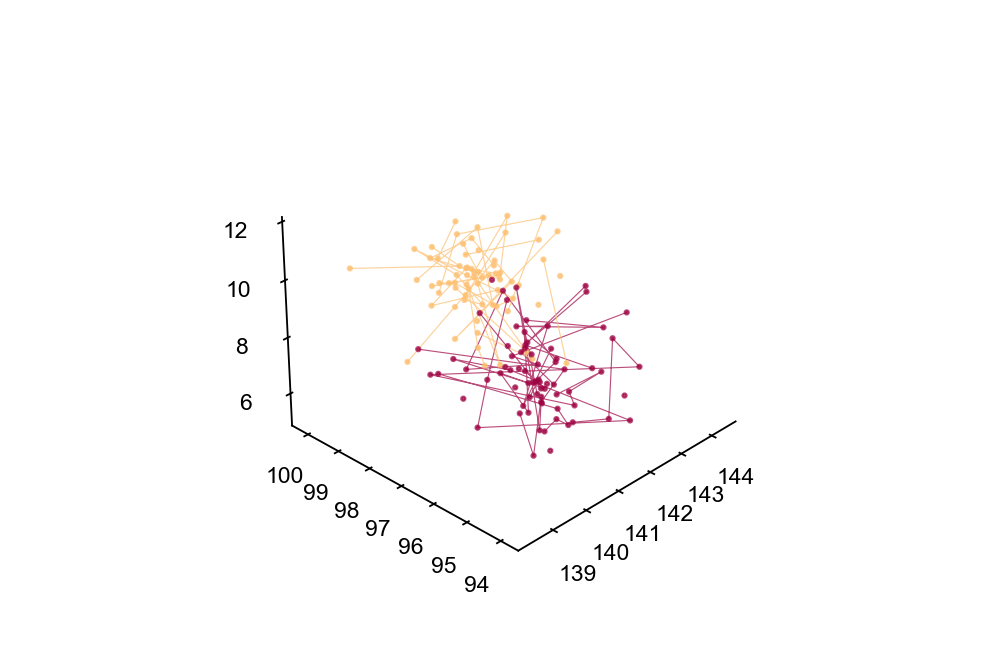

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [36]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_chr_name = '11'
_zxys_list = np.array(decoder.chr_2_zxys_list[_chr_name])/1000

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

angle = 2
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=30)
ani.save(os.path.join(decode_figure_folder, 
                      os.path.basename(decoder.savefile).replace('.hdf5', f'_Picked_chr-{_chr_name}.gif')), 
         writer=animation.PillowWriter(fps=30))

plt.show()

## 3.5 process all

In [82]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))
with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

18589


ValueError: operands could not be broadcast together with shapes (2,) (0,) 

In [74]:
len(decode_args)

1630